In [24]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore",category = DeprecationWarning)
%matplotlib inline


Read both datasets, train and test sets from the csv files provided

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Displays the top 5 rows in the train to understand how the dataset is structured

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Displays the top 5 rows in the set to understand how the dataset is structured

In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


add both sets together to be able to preprocess them all in one place instead of doing the same preproccessing the seperately

In [5]:
combination = train.append(test,ignore_index=True)

In [6]:
combination.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


delete_substr is a function that finds all the strings that contain a specific substring and delete this substring
it uses regular expressions to simplify the code instead of writing a full substring finding algorithm

In [7]:
def delete_substr(string, substr):
    changes = re.findall(substr,string)
    for word in changes:
        string = re.sub(word,"",string)
    return string

The following three lines of code, they create a new column in the data set called "cleaned tweet" where the cleaned text will be saved during the preprocessing phase

The first line, deletes all the words that contain the symbol @ followed by any number letters or as written in the regex, $W^*$
this is done by using the function numpy.vectorize, which takes each row in the dataset and performs a function on it. this function will be delete_substring() that we defined before. passing the field tweet specifically to this function as the string and the reguler expression $@(W)*$ as the substring. so all the tweets that contains any mentions to other accounts, the model will delete these mentions

In [8]:
combination["cleaned tweet"] = np.vectorize(delete_substr)(combination["tweet"], "@[\w]*")

This line removes all the punctuation symbols from the tweets. this is done by taking the cleaned tweet field that was initalized in the last line,
then it searchs for each symbol using a regular expression, and it replaces each symbol with an empty string, thus, deleting it

In [9]:
combination["cleaned tweet"] = combination["cleaned tweet"].str.replace("[^a-zA-Z#]"," ",regex = True)

This line splits the clean tweet and then collect them again but it ignores all the words with length less than four. since they are considered as stopping words that will only hinder the performance of the model

In [10]:
combination["cleaned tweet"] = combination["cleaned tweet"].apply(lambda tweet: " ".join([word for word in tweet.split() if len(word) >=4]))

In [11]:
combination.head()

,id,label,tweet,cleaned tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


After cleaning the tweets, now we tokenize them, by splitting each tweet, instead of being a string it becomes a list of words

In [12]:
tokenized = combination["cleaned tweet"].apply(lambda string: string.split()) 

In [13]:
tokenized.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: cleaned tweet, dtype: object

This function uses the nltk toolkit and uses the stemmer to stem each word.... stemming is removing the unneeded prefixes and suffixes, leaving only the root of the word. so playing, played, plays, all becomes play

In [14]:
stemmer = nltk.PorterStemmer()
tokenized = tokenized.apply(lambda string: [stemmer.stem(word) for word in string])

In [15]:
tokenized.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: cleaned tweet, dtype: object

This loop rejoins the cleaned tweets, reverting them back to strings instead of list of words

In [16]:
for i in range(0,len(tokenized)):
    tokenized[i] = " ".join(tokenized[i])
combination["cleaned tweet"] = tokenized

In [17]:
combination.head()


,id,label,tweet,cleaned tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


This function uses regular expressions to detect hashtags. hashtags are any word that starts with "#" symbol with letter after it
NOTE that this regular expression uses $W^+$ instead of $W^*$ since we need to only collect hashtags, if the latter was used, the model will detect the string "#" as a hashtag even if it is not followed by any word

In [18]:
def findhashtags(string):
    hashtags = []
    for word in string:
        hashtag = re.findall(r"#(\w+)", word)
        hashtags.append(hashtag)
    return hashtags

These two lines extract all the hashtags from the dataset, but they seperate them using the "label" field in the dataset, so we end up with the non-racist hashtags in a list and the racist hashtags in another list. so we can compare between them

NOTE that we use the "label" field as a condition to include the row in our hashtags list. since the combination dataset includes both training set that has label and testing data that does not have label field. this condition will exclude the testing data from being included in these hashtags lists since they do not have a label field

In [19]:
non_racist_hashtags = findhashtags(combination["cleaned tweet"][combination["label"] == 0])
racist_hashtags = findhashtags(combination["cleaned tweet"][combination["label"] == 1])

non_racist_hashtags = sum(non_racist_hashtags,[])
racist_hashtags = sum(racist_hashtags,[])

The following lines find the frequency of each hashtag in each set, then they plot them as a "hashtag vs frequency" bar graph

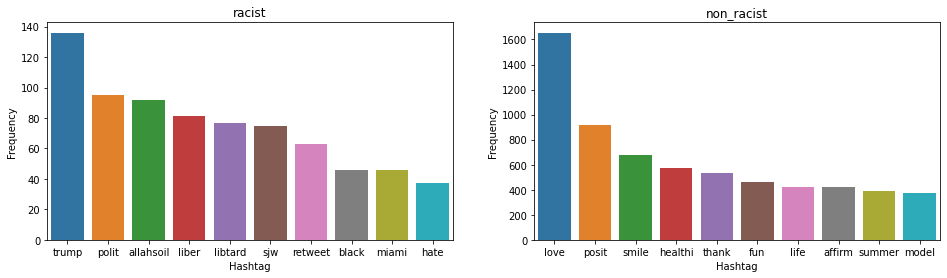

In [20]:
a_racist = nltk.FreqDist(racist_hashtags)
d_racist = pd.DataFrame(
    {
      'Hashtag': list(a_racist.keys()),
     'Frequency': list(a_racist.values())}
    )
d_racist = d_racist.nlargest(columns="Frequency", n=10)
a_non_racist = nltk.FreqDist(non_racist_hashtags)
d_non_racist = pd.DataFrame(
    {
      'Hashtag': list(a_non_racist.keys()),
     'Frequency': list(a_non_racist.values())}
    )
d_non_racist = d_non_racist.nlargest(columns="Frequency", n=10)
# plt.figure(figsize=(16,5))
fig, ax = plt.subplots(1,2, figsize = (16,4))
sns.barplot(data=d_racist, x= "Hashtag", y="Frequency",ax = ax[0])
sns.barplot(data=d_non_racist, x= "Hashtag", y="Frequency", ax = ax[1])
ax[0].set_title('racist')
ax[1].set_title('non_racist')
plt.show()

Now we start our ML model.
The approach used is th bag of words (BOW)
a simple explaination for since it's better explained with example
if we have only two tweets:
1- "Hello my name is George"
2- "I study computer science"
I'll pre process these 2 tweets, tokenized, stem and remove stopping words
let's say that my BagOfWords (bow) for some tweets are ["hello","name","George","study","computer","science"]
now this makes my bag of words consist of 6 words
I'll create 6 elements array for each tweet, where each index is the frequency of the word in this tweet
so my bow list will be
[
[1,1,1,0,0,0] ,
[0,0,0,1,1,1]
]

this is better for the ML to understand than strings

The CountVectorizer from sklearn does this function of finding the bag of words and creating the arrays for each word

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
bowVectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")
bow = bowVectorizer.fit_transform(combination['cleaned tweet'])

Now we enter the machine learning model. our model will use logistic regression rather than linear regression. since logistic is better when deciding yes/no answers, while linear regression is better for finding numbers, such as age prediction, salary prediction

In the next block, we will initialize our logistic regression model, split our training data into train & test data, with a specific ratio
we will then feed our model the training data, and let it train itself, then we give it the testing data that we splitted from the training dataset.
since the model will give a judge between 0 and 1, including the decimals between, we decided to make it consider anything above 0.2 to be considered as hatespeech

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and testing sets, we used 80:20 ratio since it maximizes the accuracy of the model
xtraining_data, xtesting_data, ytraining_data, ytesting_data = train_test_split(train_bow, train['label'], random_state=42, test_size=0.2)

lreg = LogisticRegression() # initialize the model then feed it training data
lreg.fit(xtraining_data, ytraining_data) 
# now we give it the testing data and
# let it produce its predictions as probability between 0 and 1
prediction = lreg.predict_proba(xtesting_data) 
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(np.int)
# f1-score is a metric that calculates how accurate the model is
f1_score(ytesting_data, prediction_int) 


0.5663531870428422

Now we save our predictions in a csv file
where we will save the original tweet and the decision of our model

In [23]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['tweet','label']]
submission.to_csv('logistic_regression_results.csv', index=False)